In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)

In [3]:
from google.colab import files

files.upload()

Saving train.csv to train (2).csv


{'train.csv': b'id,time,x,y\n1,0,800,0\n1,780,780,0\n1,1572,792,0\n1,2392,820,0\n1,3196,804,0\n1,4024,828,0\n1,4940,916,0\n1,5900,960,0\n1,6856,956,0\n1,7784,928,0\n1,8620,836,0\n1,9412,792,0\n1,10188,776,0\n1,10924,736,0\n1,11648,724,0\n1,12376,728,0\n1,13136,760,0\n1,13940,804,0\n1,14788,848,0\n1,15644,856,0\n1,16492,848,0\n1,17308,816,0\n1,18092,784,0\n1,18860,768,0\n1,19596,736,0\n1,20336,740,0\n1,21092,756,0\n1,21532,440,0\n1,21848,316,0\n1,22596,748,0\n1,23364,768,0\n1,24112,748,0\n1,24852,740,0\n1,25608,756,0\n1,26380,772,0\n1,27160,780,0\n1,27912,752,0\n1,28664,752,0\n1,29428,764,0\n1,30192,764,0\n1,30948,756,0\n1,31700,752,0\n1,32420,720,0\n1,33136,716,0\n1,33856,720,0\n1,34584,728,0\n1,35304,720,0\n1,36052,748,0\n1,36816,764,0\n1,37608,792,0\n1,38456,848,0\n1,39320,864,0\n1,40176,856,0\n1,41008,832,0\n1,41804,796,0\n1,42560,756,0\n1,43288,728,0\n1,44020,732,0\n1,44748,728,0\n1,45472,724,0\n1,46192,720,0\n1,46896,704,0\n1,47592,696,0\n1,48288,696,0\n1,48960,672,0\n1,49624,664,

In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0


In [5]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

train_inds, test_inds = next(GroupShuffleSplit(test_size=.25, n_splits=2, random_state = 42).split(df, groups=df['id']))

train = df.iloc[train_inds][7:]
test = df.iloc[test_inds]
train.shape, test.shape

((44544, 4), (15936, 4))

In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = train['x'].mean()
training_std = train['x'].std()
X_train = (train['x'] - training_mean) / training_std

test_mean = test['x'].mean()
test_std = test['x'].std()
X_test = (test['x'] - test_mean) / test_std

Y_train = train['y']
Y_test = test['y']

In [8]:
train_loader = torch.utils.data.DataLoader(list(zip(X_train.values , Y_train.values)), batch_size=64)
val_loader = torch.utils.data.DataLoader(list(zip(X_test.values , Y_test.values)), batch_size=64)

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.ReLU(), 
            nn.Conv1d(16, 16, kernel_size=5, padding=2),
            nn.ReLU(), )
        self.pool0 =   nn.MaxPool1d(kernel_size=2)

        # bottleneck
        self.bottleneck_conv = nn.Dropout(p=0.2)

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=7, padding=3),
            nn.Sigmoid(),)

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))

        # bottleneck
        b = self.bottleneck_conv(e0)

        # decoder
        d1 = self.upsample0(self.dec_conv0(torch.cat((b, e0), dim=1)))
        return d1

model = UNet()

In [16]:
n_epochs = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss() 
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(X_batch.to(dtype=torch.float).view(1,1,64))
        loss = loss_fn(pred , Y_batch.to(dtype=torch.float).view(1,1,64))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch,Y_batch in val_loader:
          pred = model(X_batch.to(dtype=torch.float).view(1,1,64))
          loss = loss_fn(pred , Y_batch.to(dtype=torch.float).view(1,1,64))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


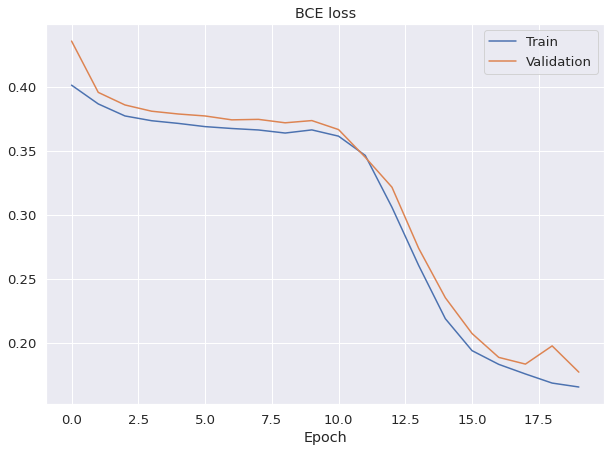

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('BCE loss')
plt.legend()
plt.show()

In [18]:
pred = model(torch.FloatTensor(X_test.values).to(dtype=torch.float).view(1,1,15936))

In [19]:
gd = torch.FloatTensor(Y_test.values).to(dtype=torch.float).view(1,1,15936)

In [20]:
from sklearn.metrics import f1_score

f1_score(gd.detach().numpy()[0][0], np.rint(pred.detach().numpy()[0][0] ))

0.7810014038371549